<a href="https://colab.research.google.com/github/esdrasantos/statistical-concepts-and-practice/blob/main/cstfm_mod_9_anova_2_factors_descr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [677]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [678]:
import numpy as np
import pandas as pd
import os
import re
import datetime

# Buscando dados de tabelas .csv hospedadas no google drive⚡

In [679]:
dir = '/content/drive/MyDrive/faturas_nu_csv'

arquivos = [arquivo for arquivo in os.listdir(dir)]

padrao = f"_(.*?)-"

arquivosord = sorted(arquivos, key=lambda x: int(re.findall(padrao, x)[0]))
arquivosord = sorted(arquivosord, key=lambda x: int(x.split('-')[1]))
arquivosord

['Nubank_2025-01-11.csv',
 'Nubank_2025-02-11.csv',
 'Nubank_2025-03-11.csv',
 'Nubank_2025-04-11.csv',
 'Nubank_2025-05-11.csv',
 'Nubank_2025-06-11.csv',
 'Nubank_2025-07-11.csv',
 'Nubank_2025-08-11.csv',
 'Nubank_2025-09-11.csv',
 'Nubank_2025-10-11.csv',
 'Nubank_2025-11-11.csv']

In [680]:
dados = pd.DataFrame()

for arquivo in arquivosord:
  tabela = pd.read_csv(f'{dir}/{arquivo}')
  tabela['Arquivo Origem'] = arquivo
  dados = pd.concat([dados,tabela])

dados.reset_index(drop=True,inplace=True)

In [681]:
dados['Fech. Fatura'] = dados['Arquivo Origem']\
.str.rsplit('_', n=1).str[1]\
.str.split('.').str[0]

# Corrigindo as datas das observações e preparando dados ⛴

In [682]:
dia_mes = dados['Data'].str.split(' ')
dados['Dia'] = dia_mes.str[0].str.strip()
dados['Mes'] = dia_mes.str[1].str.strip()
dados['Ano'] = dados['Fech. Fatura'].str\
              .split('-').str[0]\
              .str.strip()
meses = {
    "JAN": 1,
    "FEV": 2,
    "MAR": 3,
    "ABR": 4,
    "MAI": 5,
    "JUN": 6,
    "JUL": 7,
    "AGO": 8,
    "SET": 9,
    "OUT": 10,
    "NOV": 11,
    "DEZ": 12
}

dados['N Mes'] = dados['Mes'].map(meses)

dados['Data_Compra_Aux'] = dados.Ano + "-"\
                           + dados['N Mes'].astype(str) + "-"\
                           + dados.Dia

In [683]:
dados.drop(columns=['Dia','Mes','Ano','N Mes'],inplace=True)

In [684]:
dtdiff = pd.to_datetime(dados['Fech. Fatura'])-pd.to_datetime(dados['Data_Compra_Aux'])
dados['Dias_Compra'] = dtdiff.dt.days

In [685]:
dados.drop(columns=["Data"], inplace=True)

In [686]:
from dateutil.relativedelta import relativedelta

In [687]:
dados['Data'] = pd.to_datetime(dados['Data_Compra_Aux'])
filtro = dados['Dias_Compra'] < 0
dados.loc[filtro, 'Data'] = dados.loc[filtro, 'Data'] - pd.DateOffset(years=1)

In [688]:
dados.drop(columns=['Data_Compra_Aux', 'Dias_Compra'],inplace=True)

In [689]:
dados['Mes Compra'] = dados['Data'].dt.month
dados['Semana Compra'] = dados['Data'].dt.isocalendar().week

In [690]:
def semana_do_mes(data):
    return data.day // 7 + 1

semana_do_mes(pd.to_datetime('2025-12-31'))

5

In [691]:
datas = dados[['Data']].copy()
print(datas.head())


        Data
0 2024-12-01
1 2024-12-04
2 2024-12-04
3 2024-12-04
4 2024-12-04


In [692]:
datas['SemanaMes'] = datas.apply(lambda x: semana_do_mes(pd.to_datetime(x['Data'])), axis=1)

In [693]:
dados['SemanaMes'] = datas['SemanaMes']
dados['Ano'] = datas['Data'].dt.year
dados['Mes'] = datas['Data'].dt.month

In [694]:
dados.drop(columns=['Arquivo Origem', 'Fech. Fatura', 'Compra'],inplace=True)
print(dados.head())

      Valor             Categoria       Data  Mes Compra  Semana Compra  \
0  R$ 12,99            Transporte 2024-12-01          12             48   
1  R$ 53,28  Shopping e ecommerce 2024-12-04          12             49   
2  R$ 75,50  Shopping e ecommerce 2024-12-04          12             49   
3  R$ 53,13  Shopping e ecommerce 2024-12-04          12             49   
4  R$ 55,20  Shopping e ecommerce 2024-12-04          12             49   

   SemanaMes   Ano  Mes  
0          1  2024   12  
1          1  2024   12  
2          1  2024   12  
3          1  2024   12  
4          1  2024   12  


# Definindo dimensões para ANOVA 2 VIAS

In [695]:
df = dados.copy()
df['Valor'] = df['Valor'].astype(str)
df['Valor'] = df['Valor'].str.replace('R$', '')
df['Valor'] = df['Valor'].str.replace(',', '.')
df['Valor'] = df['Valor'].str.replace(r'\.(?=.*\.)', '', regex=True)

In [696]:
df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')


In [697]:
df['Mes Ano'] = df['Mes'].astype(str) + '-' + df['Ano'].astype(str)
df.drop(columns=['Categoria','Data','Semana Compra'],inplace=True)

In [698]:
df.sort_values(by=['Ano','Mes', 'SemanaMes'], inplace=True)

In [699]:
df_ = df.copy()
df_.drop(columns=['Mes Ano', 'Mes Compra'],inplace=True)
df_.reset_index(drop=True,inplace=True)
print(df_.head())

   Valor  SemanaMes   Ano  Mes
0  12.99          1  2024   12
1  53.28          1  2024   12
2  75.50          1  2024   12
3  53.13          1  2024   12
4  55.20          1  2024   12


In [700]:
ssm = df_.groupby(['Ano','Mes','SemanaMes']).sum()

print(ssm.head())

                      Valor
Ano  Mes SemanaMes         
2024 12  1           548.55
         2          2247.00
         3           558.87
         4           898.76
         5           234.27


In [701]:
ssm['AnoMes'] = ssm.index.get_level_values(0).astype(str) + '-' \
+ ssm.index.get_level_values(1).astype(str)
ssm.reset_index(inplace=True)

In [702]:
ssm.drop(columns=['Ano','Mes'],inplace=True)

In [703]:
print(ssm.head())

   SemanaMes    Valor   AnoMes
0          1   548.55  2024-12
1          2  2247.00  2024-12
2          3   558.87  2024-12
3          4   898.76  2024-12
4          5   234.27  2024-12


# ANOVA 1 VIA IMPACTO ANO MES

1️⃣ Valor ~ AnoMes

Diferença de médias de Valor entre os meses, ignorando o efeito das semanas.

*Hipóteses*

H₀: As médias de Valor são iguais para todos os AnoMes.

H₁: Pelo menos um AnoMes possui média de Valor diferente.

*Interpretação se p-valor < α*

Há evidência estatística de que os valores médios diferem entre meses.

In [704]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols('Valor ~ AnoMes', data=ssm).fit()
tb_anova = sm.stats.anova_lm(model, typ=2)
print('Table for Valor ~ AnoMes')
print(tb_anova)

Table for Valor ~ AnoMes
                sum_sq    df         F    PR(>F)
AnoMes    7.985285e+05  11.0  0.200457  0.996742
Residual  1.593414e+07  44.0       NaN       NaN


# ANOVA 1 VIA IMPACTO SEMANA DO MES

2️⃣ Valor ~ SemanaMes

Diferença de médias de Valor entre as semanas, considerando todas as semanas de todos os meses juntas.

*Hipóteses*

H₀: As médias de Valor são iguais para todas as SemanaMes.

H₁: Pelo menos uma semana possui média de Valor diferente.

*Interpretação se p-valor < α*

Existe um padrão semanal global, ou seja, algumas semanas têm valores médios diferentes, independentemente do mês.

In [705]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols('Valor ~ SemanaMes', data=ssm).fit()
tb_anova = sm.stats.anova_lm(model, typ=2)
print('Table for Valor ~ SemanaMes')
print(tb_anova)

Table for Valor ~ SemanaMes
                 sum_sq    df          F        PR(>F)
SemanaMes  7.043759e+06   1.0  39.257556  6.377861e-08
Residual   9.688912e+06  54.0        NaN           NaN


# ANOVA 2 VIAS MES E SEMANA DO MES (ADITIVO)
3️⃣ Valor ~ AnoMes + SemanaMes

Diferença entre meses ajustada pelas semanas e diferença entre semanas ajustada pelos meses
(modelo aditivo, sem interação).

*Hipóteses Para AnoMes*

H₀: As médias de Valor são iguais entre os meses, controlando o efeito da semana.
H₁: Pelo menos um mês difere em média, mesmo após ajustar pelas semanas.

*Para SemanaMes*

H₀: As médias de Valor são iguais entre as semanas, controlando o efeito do mês.

H₁: Pelo menos uma semana difere em média, mesmo após ajustar pelos meses.

*Interpretação se p-valor < α*

O fator (mês ou semana) possui efeito significativo próprio, independentemente do outro.

In [706]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# First is the numeric column, always. Then, the categorics.
model = smf.ols('Valor ~ AnoMes + SemanaMes', data=ssm).fit()
tb_anova = sm.stats.anova_lm(model, typ=2)
print('Table for Valor ~ AnoMes + SemanaMes')
print(tb_anova)

Table for Valor ~ AnoMes + SemanaMes
                 sum_sq    df          F        PR(>F)
AnoMes     1.727434e+06  11.0   0.848172  5.948856e-01
SemanaMes  7.972665e+06   1.0  43.060425  5.561166e-08
Residual   7.961477e+06  43.0        NaN           NaN


In [707]:
pvalor_ano_mes = tb_anova['PR(>F)']['AnoMes']
pvalor_semana_mes = tb_anova['PR(>F)']['SemanaMes']

print('Ano Mes', pvalor_ano_mes)
print('Semana Mes', pvalor_semana_mes)

Ano Mes 0.5948855596811014
Semana Mes 5.561166168134182e-08


# ANOVA 2 VIAS COM INTERACAO MES E SEMANA DO MES

4️⃣ Valor ~ AnoMes + SemanaMes + AnoMes:SemanaMes

Diferença entre meses, diferença entre semanas e se o efeito da semana depende do mês
(modelo com interação).

*Hipóteses Para AnoMes*

H₀: Não há diferença média entre os meses, após considerar semanas e interação.

H₁: Existe diferença média entre meses.

*Para SemanaMes*
H₀: Não há diferença média entre as semanas, após considerar meses e interação.

H₁: Existe diferença média entre semanas.

*Para AnoMes:SemanaMes (interação)*
H₀: O efeito da semana é o mesmo em todos os meses.

H₁: O efeito da semana varia conforme o mês.

*Interpretação se p-valor < α*

Interação significativa: o padrão semanal muda de mês para mês; efeitos principais não devem ser interpretados isoladamente.

Interação não significativa: o padrão semanal é consistente entre os meses.

In [708]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# First is the numeric column, always. Then, the categorics.
model = smf.ols('Valor ~ AnoMes + SemanaMes + AnoMes:SemanaMes', data=ssm).fit()
tb_anova = sm.stats.anova_lm(model, typ=2)
print('Valor ~ AnoMes + SemanaMes + AnoMes:SemanaMes')
print(tb_anova)

Valor ~ AnoMes + SemanaMes + AnoMes:SemanaMes
                        sum_sq    df          F        PR(>F)
AnoMes            7.789878e+05  11.0   0.370745  9.507041e-01
SemanaMes         7.237751e+06   1.0  37.891477  6.107460e-07
AnoMes:SemanaMes  2.677324e+06  11.0   1.274225  2.816275e-01
Residual          6.303417e+06  33.0        NaN           NaN


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 10
  warnings.warn('covariance of constraints does not have full '


# Analisando resultados significativos
Que rejeitaram a hipótese nula Ho.

p-valor < α

In [709]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols('Valor ~ SemanaMes', data=ssm).fit()
tb_anova = sm.stats.anova_lm(model, typ=2)
print('Table for Valor ~ SemanaMes')
print(tb_anova)

Table for Valor ~ SemanaMes
                 sum_sq    df          F        PR(>F)
SemanaMes  7.043759e+06   1.0  39.257556  6.377861e-08
Residual   9.688912e+06  54.0        NaN           NaN


## Plot do Residuo (Erro)

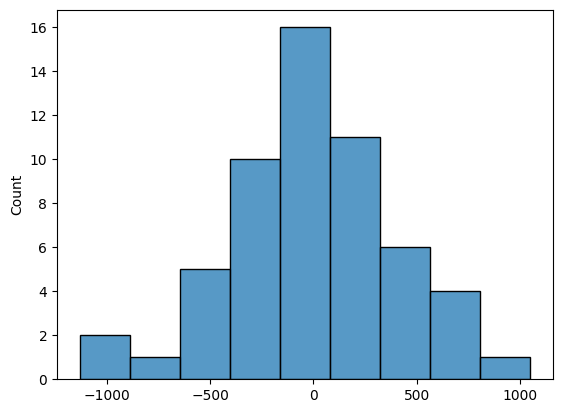

In [710]:
import matplotlib.pyplot as plt
import seaborn as sns

residue = model.resid
sns.histplot(residue)
plt.show()

## Teste Shapiro-Wilk para normalidade de residuo

In [711]:
import scipy.stats as stats

stat, pvalue= stats.shapiro(residue)

print('stat=%.3f, p-value=%.3f' % (stat, pvalue))

# Decisão

if pvalue < 0.05:
  print('Não é normal')
else:
  print('É normal')

stat=0.991, p-value=0.940
É normal


## Teste Levene para Homoscedasticidade

Verifica se as variâncias entre os k grupos são similares.
Só faz sentido se a distribuição dos resíduos for normal.

In [713]:
from scipy.stats import levene

groups = ssm.groupby(['AnoMes','SemanaMes'])['Valor'].apply(list)

print(groups.head())

AnoMes   SemanaMes
2024-12  1                        [548.55]
         2                        [2247.0]
         3                        [558.87]
         4                        [898.76]
         5            [234.26999999999998]
Name: Valor, dtype: object


In [716]:
stat, p_valor = levene(*groups)

print('stat=%.3f, p-value=%.3f' % (stat, p_valor))

stat=nan, p-value=nan


In [717]:
# Decision for Levenes's

alpha = 0.05

if p_valor > alpha:
  print('Homoscedasticity: variancias similares nos grupos')
else:
  print('Heteroscedasticity: variancias diferentes nos grupos')

Heteroscedasticity: different variances of categories
